In [2]:
import polars as pl
from matplotlib import pyplot as plt
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler
from utils import adjacencyplot, cell_type_palette
import seaborn as sns

In [2]:
conn_df = pl.read_delta("../results/cellcellconnectivitylong/")
result = conn_df.filter(pl.col("measurement_type") == "SUM_ANATOMICAL_SIZE")

datasets = pl.read_delta("../results/dataset/")
datasets

id,name,publication,modality,project_id
str,str,str,str,str
"""minnie65_v1412_csm_cluster""","""Minnie65 v1412 CSM Dendrite Ul…","""none""","""ELECTRON_MICROSCOPY""","""minnie65"""
"""minnie65_v1412_proofread""","""Minnie65 v1412 Cells With Proo…","""none""","""ELECTRON_MICROSCOPY""","""minnie65"""


In [3]:
result.to_pandas()

,id,description,presynaptic_cell,postsynaptic_cell,modality,value,unit,project_id,measurement_type
0,43176584,None,337175,304043,None,5984.0,ARBITRARY_UNIT,minnie65,SUM_ANATOMICAL_SIZE
1,43181492,None,330167,339142,None,5920.0,ARBITRARY_UNIT,minnie65,SUM_ANATOMICAL_SIZE
2,43181499,None,273595,339142,None,3852.0,ARBITRARY_UNIT,minnie65,SUM_ANATOMICAL_SIZE
3,43183398,None,301121,339142,None,11504.0,ARBITRARY_UNIT,minnie65,SUM_ANATOMICAL_SIZE
4,43183978,None,273595,205051,None,6244.0,ARBITRARY_UNIT,minnie65,SUM_ANATOMICAL_SIZE
...,...,...,...,...,...,...,...,...,...
796093,303199984,None,497103,422139,None,4872.0,ARBITRARY_UNIT,minnie65,SUM_ANATOMICAL_SIZE
796094,303200956,None,463716,422139,None,2220.0,ARBITRARY_UNIT,minnie65,SUM_ANATOMICAL_SIZE
796095,303201438,None,490761,422139,None,2904.0,ARBITRARY_UNIT,minnie65,SUM_ANATOMICAL_SIZE
796096,303201480,None,363525,422139,None,5148.0,ARBITRARY_UNIT,minnie65,SUM_ANATOMICAL_SIZE


In [4]:
data_items = pl.read_delta("../results/dataitem_dataset_association/")
prf_cells=data_items.filter(pl.col("dataset_id") == "minnie65_v1412_proofread")
feat_cells= data_items.filter(pl.col("dataset_id") == "minnie65_v1412_csm_cluster")

In [5]:
clusters=pl.read_delta("../results/cluster/")
cluster_members = pl.read_delta("../results/clustermembership/")
cell_types=cluster_members.join(clusters, left_on="cluster", right_on="id").filter(pl.col("level") == 2)


In [6]:
cell_types

item,cluster,membership_score,probability,distance,project_id,parent,children,level,score,distance_to_parent,project_id_right
str,str,f64,f64,f64,str,str,list[str],i64,f64,f64,str
"""204945""","""L6CT""",null,null,null,"""minnie65""","""excitatory""",null,2,null,null,"""minnie65"""
"""524777""","""L4IT""",null,null,null,"""minnie65""","""excitatory""",null,2,null,null,"""minnie65"""
"""407636""","""L6CT""",null,null,null,"""minnie65""","""excitatory""",null,2,null,null,"""minnie65"""
"""493863""","""L5IT""",null,null,null,"""minnie65""","""excitatory""",null,2,null,null,"""minnie65"""
"""565653""","""L6CT""",null,null,null,"""minnie65""","""excitatory""",null,2,null,null,"""minnie65"""
…,…,…,…,…,…,…,…,…,…,…,…
"""269402""","""L5IT""",null,null,null,"""minnie65""","""excitatory""",null,2,null,null,"""minnie65"""
"""311962""","""L6CT""",null,null,null,"""minnie65""","""excitatory""",null,2,null,null,"""minnie65"""
"""269817""","""L6IT""",null,null,null,"""minnie65""","""excitatory""",null,2,null,null,"""minnie65"""


In [7]:
cell_features = pl.read_delta("../results/cellfeatures/csm_cluster_features")
nodes=cell_types.select(["item", "cluster", "parent"]).join(cell_features, left_on="item", right_on="id")

In [ ]:
cell_feature_sets = pl.read_delta("../results/cellfeatureset/")
feature_set = cell_feature_sets.filter(pl.col("id") == "csm_cluster_features").select("id").item()
features = pl.read_delta("../results/cellfeaturedefinition/").filter(pl.col("feature_set_id") == feature_set)
features

id,nucleus_volume_um,nucleus_area_um,nuclear_area_to_volume_ratio,nuclear_folding_area_um,fraction_nuclear_folding,nucleus_to_soma_ratio,soma_volume_um,soma_area_um,soma_to_nucleus_center_dist,soma_area_to_volume_ratio,soma_synapse_density_um,tip_len_dist_dendrite_p75,tip_tort_dendrite_p75,num_syn_dendrite,num_syn_soma,path_length_dendrite,radial_extent_dendrite,syn_dist_distribution_dendrite_p50,syn_size_distribution_soma_p50,syn_size_distribution_dendrite_p50,syn_size_distribution_dendrite_p5,syn_size_distribution_dendrite_p95,syn_size_dendrite_cv,syn_depth_dist_p1,syn_depth_dist_p99,syn_depth_extent,median_density,radius_dist,area_factor,dendrite_length_binned_0,dendrite_length_binned_1,dendrite_length_binned_2,dendrite_length_binned_3,syn_dist_distribution_dendrite_spine_p50,syn_dist_distribution_dendrite_shaft_p50,dend_spine_shaft_offset,…,median_density_shaft,syn_spine_shaft_ratio_dendrite,num_spine_syn_dendrite,num_shaft_syn_dendrite,num_spine_syn_soma,syn_count_dist_binned_shaft_0,syn_count_dist_binned_shaft_1,syn_count_dist_binned_shaft_2,syn_count_dist_binned_shaft_3,syn_count_dist_binned_spine_0,syn_count_dist_binned_spine_1,syn_count_dist_binned_spine_2,syn_count_dist_binned_spine_3,syn_count_dist_binned_ratio_0,syn_count_dist_binned_ratio_1,syn_count_dist_binned_ratio_2,syn_count_dist_binned_ratio_3,syn_count_pca0,syn_count_pca1,syn_count_pca2,syn_count_pca3,syn_count_pca4,syn_count_pca5,syn_count_pca6,syn_count_pca7,syn_count_pca8,syn_count_pca9,branch_svd0,branch_svd1,branch_svd2,branch_svd3,branch_svd4,ego_count_pca0,ego_count_pca1,ego_count_pca2,project_id,feature_set_id
str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,f32,f32,f32,i32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str,str
"""485509""",344.116638,269.338379,0.782695,4.873741e6,0.017687,0.309179,1112.999878,1202.533447,537.42511,1.080443,0.15817,147.846939,1.264484,6768,117,4849.900391,227.368088,88.470299,3532,4340,596,28359,1.170447,27.544989,173.108597,145.563599,1.422885,385.890778,2.670925,818.647766,1723.804077,1067.032959,438.294983,88.60463,90.456306,-1.851673,…,0.414144,1.269837,4718,1956,0,371,721,407,209,606,2213,1268,405,0.706394,1.616585,1.637051,0.95109,5.812237,0.119504,-0.61887,-0.880462,-0.127526,-0.166496,0.165302,-0.123148,1.384805,-0.181554,62.978085,0.950874,0.729539,-1.328438,4.192588,1.960875,0.805681,-0.739578,"""minnie65""","""csm_cluster_features"""
"""263203""",254.538391,250.433167,0.983872,3.075656e7,0.123807,0.397382,640.53772,934.029358,361.333221,1.458196,0.119974,152.7453,1.301633,2036,45,2394.644043,115.675705,74.979202,4564,4618,737,21603,0.944691,23.207253,425.879395,402.672119,0.860583,319.731171,2.512924,508.080261,855.880737,473.234985,117.005539,76.613541,74.566284,2.047251,…,0.189176,1.760139,1547,456,2,133,165,78,18,339,729,340,70,1.343302,2.136713,2.109847,1.90182,-1.764601,-2.52387,-0.272709,-2.189014,-1.03418,-0.030833,0.031632,-0.05569,0.326676,-2.280065,31.198191,-4.262416,0.754856,1.729803,1.534398,0.588246,-0.777625,-0.096427,"""minnie65""","""csm_cluster_features"""
"""456177""",338.026459,298.603607,0.883373,3.5204028e7,0.124294,0.366174,923.129578,1017.687988,365.622009,1.102432,0.189111,153.671768,1.35095,4380,124,4331.236816,107.554108,86.69693,4408,5460,695,26492,0.97058,14.459391,330.694427,316.235046,1.02033,333.71936,2.624826,639.515625,1594.599854,1216.418457,168.38266,88.55098,86.423515,2.127462,…,0.27645,1.333254,3068,1217,0,246,446,278,56,406,1462,951,101,0.720518,1.710583,1.770696,0.839535,-0.915223,-1.138865,-0.62281,4.627585,-0.271961,-0.14354,0.484421,-0.112422,0.98503,-0.476574,56.717365,4.266992,9.26533,-0.329062,7.591257,-0.729798,-0.946995,0.546816,"""minnie65""","""csm_cluster_features"""
"""461339""",328.602386,300.213623,0.913608,3.8599868e7,0.126401,0.324381,1013.014954,1051.013306,1082.797363,1.03

In [11]:
feature_set

NameError: name 'feature_set' is not defined

In [9]:
cell_type_palette = {
    "L2IT": [0.9075666881074735, 0.7831311441799196, 0.6949858653492867],
    "L3IT": [0.8708834148859907, 0.6888410680873137, 0.6022311567741945],
    "L4IT": [0.8274067443395999, 0.5906550752430283, 0.5233409192850811],
    "L5ET": [0.7795806757764551, 0.5022849626842287, 0.4643377130216367],
    "L5IT": [0.719621740596695, 0.41459615740890743, 0.41383679416754976],
    "L5NP": [0.6539490167887168, 0.3392197573102502, 0.37390086854124416],
    "L6CT": [0.5747615524284997, 0.26764431745066686, 0.3354259029195752],
    "L6IT": [0.4927058890394963, 0.20865645456553394, 0.299493097642672],
    "DTC": [0.5054276262176057, 0.7742578554634272, 0.7550447895194092],
    "ITC": [0.307398668309227, 0.535864603420623, 0.6514437955029915],
    "PTC": [0.21347879954025112, 0.2909729895091856, 0.47951242239001035],
    "STC": [0.12751763609942932, 0.10157769757635066, 0.2292792004813278],
    "excitatory": [0.72830947, 0.47437862, 0.46344404],
    "inhibitory": [0.28845568, 0.42566829, 0.52882005],
}

In [10]:
# df=result.to_pandas()
# node_df = nodes.to_pandas()
# df['log_syanpse_size'] = np.log(df.value)
# f, ax = plt.subplots(figsize=(8,24))
# adjacencyplot(df,
#               node_df,
#               node_id_col="item",
#               row_groupby=["parent", "cluster"],
#               col_groupby=["parent", "cluster"],
#               col_sortby=["median_density"],
#               node_palette=cell_type_palette,
#               pre_id_col="postsynaptic_cell",
#               post_id_col="presynaptic_cell",
#               arc_labels = None,
#               weight_col="log_syanpse_size",
#               plot_type="scattermap",
#               row_value_bars=["soma_volume_um","median_density"],
#               col_value_bars=["soma_volume_um","median_density"],
#               edge_hue=False,
#               hue_norm=(1,10),
#               sizes = (.1, 2),
#               size_norm=(0,13),
#               ax=ax)

In [11]:
# f.savefig("../figures/celltype_connectivity_adjacency_plot.png")

In [12]:
cell_feature_sets = pl.read_delta("../results/cellfeatureset/")
feature_set = cell_feature_sets.filter(pl.col("id") == "csm_cluster_features")
features = pl.read_delta("../results/cellfeaturedefinition/").filter(pl.col("id").is_in(feature_set['feature_definition_ids']))
features

id,description,unit,data_type,range_min,range_max
str,str,str,str,f64,f64
"""nucleus_volume_um""","""Nucleus volume""","""MICRONS_CUBED""","""<f4""",0.0,NaN
"""nucleus_area_um""","""Nucleus surface area""","""MICRONS_SQUARE""","""<f4""",0.0,NaN
"""nuclear_area_to_volume_ratio""","""Nucleus surface area to volume…","""MICRONS_INVERSE""","""<f4""",0.0,NaN
"""nuclear_folding_area_um""","""Area of nucleus in an infoldin…","""MICRONS_SQUARE""","""<f4""",0.0,NaN
"""fraction_nuclear_folding""","""Fraction of nucleus in an info…","""RATIO""","""<f4""",0.0,1.0
…,…,…,…,…,…
"""branch_svd3""","""SVD loading dendritic path len…","""RATIO""","""<f4""",NaN,NaN
"""branch_svd4""","""SVD loading dendritic path len…","""RATIO""","""<f4""",NaN,NaN
"""ego_count_pca0""","""PC loading synapse depth relat…","""RATIO""","""<f4""",NaN,NaN


In [3]:
clusters = pl.read_delta("../results/cluster/")
clusters


id,parent,children,level,score,hex_color,heirachy_category,distance_to_parent,project_id
str,str,list[str],i64,f64,str,str,f64,str
"""neuron""",null,"[""excitatory"", ""inhibitory""]",0,null,"""#000000""","""major_class""",null,"""minnie65"""
"""gabaergic""","""neuron""","[""PTC"", ""DTC"", … ""STC""]",1,null,"""#0000FF""","""class""",null,"""minnie65"""
"""glutamatergic""","""neuron""","[""L4IT"", ""L6CT"", … ""L6SP""]",1,null,"""#FF0000""","""class""",null,"""minnie65"""
"""PTC""","""gabaergic""",null,2,null,"""#364a7a""","""subtype""",null,"""minnie65"""
"""DTC""","""gabaergic""",null,2,null,"""#80c5c0""","""subtype""",null,"""minnie65"""
…,…,…,…,…,…,…,…,…
"""L5IT""","""glutamatergic""",null,2,null,"""#b76969""","""subtype""",null,"""minnie65"""
"""L6IT""","""glutamatergic""",null,2,null,"""#7d354c""","""subtype""",null,"""minnie65"""
"""L5ET""","""glutamatergic""",null,2,null,"""#c68076""","""subtype""",null,"""minnie65"""


In [18]:
umap = pl.read_delta("../results/cellfeatures/csm_cluster_features_umap").drop(['project_id','feature_set_id'])
cell_cluster = pl.read_delta("../results/clustermembership").select(['item', 'cluster'])
anatomy = pl.read_delta("../results/cellfeatures/minnie65_std_transform_coordinates").drop(['project_id','feature_set_id'])
nodes=cell_cluster.join(umap, left_on='item', right_on='id').join(anatomy, left_on='item', right_on='id')


In [31]:
pallete = {}
for row in clusters.select(['id', 'hex_color']).rows():
    pallete[row[0]]=row[1]

('neuron', '#000000')

ValueError: The palette dictionary is missing keys: {'inhibitory', 'excitatory'}

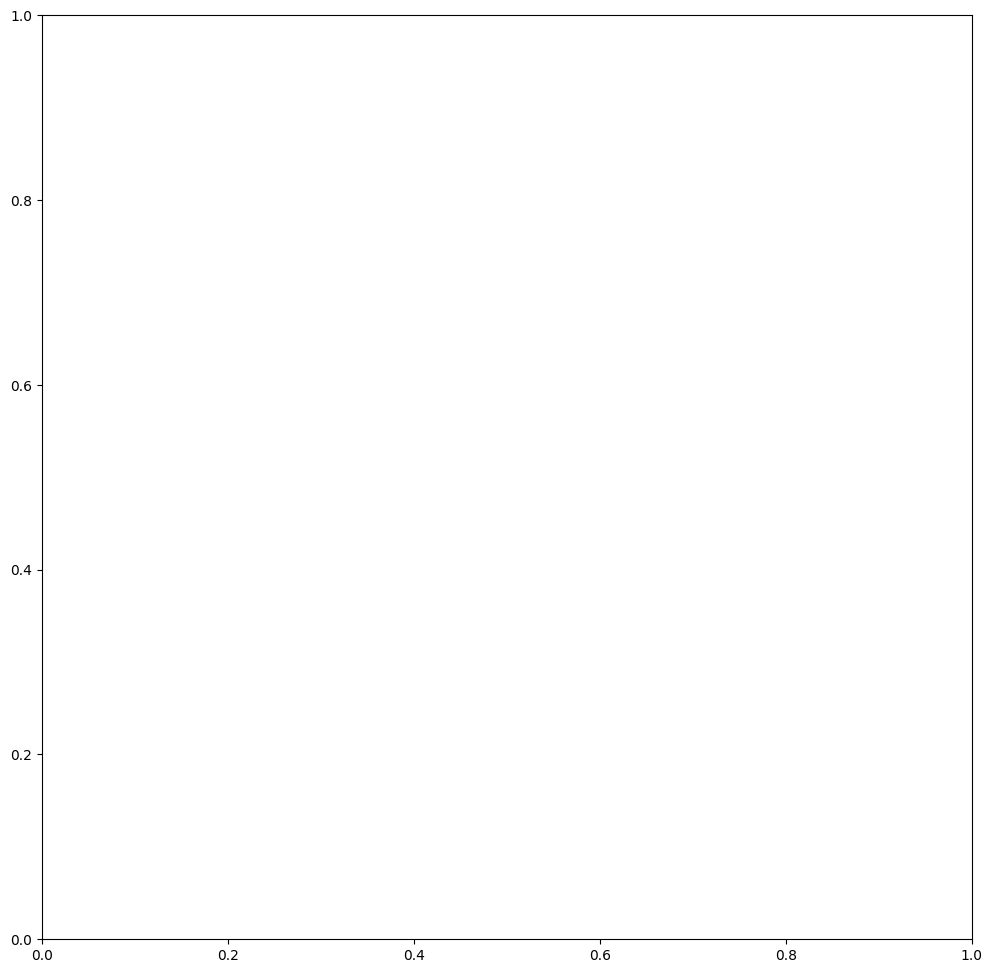

In [32]:
f, ax = plt.subplots(figsize=(12,12))

sns.scatterplot(data=nodes,
                x='x_umap',
                y='y_umap',
                hue='cluster',
                s=5,
                palette=pallete, 
                linewidths=0, ax=ax)

In [21]:
nodes['umap_x']

umap_x
f32
10.046968
11.809131
11.228506
8.968147
9.316358
…
9.66165
10.784261
10.407284
